# Exploratory Data Analysis

Now that we've cleaned and parsed the data, we can start exploring it and looking for some initial insights.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import numpy as np
import seaborn as sns

## Data Loading

In [2]:
df = pd.read_csv('../Data/parsed_data.csv')

We're going to drop the features that we've noted to be difficult to work with, in the future this may change as I learn more.

In [3]:
drop_features = ['plot', 'metacritic', 'production', 'actors', 'poster', 'director', 'keywords']
df = df.drop(drop_features, axis = 1)

Now we have to fix datatypes that we lost in conversion.

In [25]:
df[df.columns[12:35]] = df[df.columns[12:35]].astype('category')

In [26]:
df[df.columns[37:53]] = df[df.columns[37:53]].astype('category')

In [27]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['dvd_release'] = pd.to_datetime(df['dvd_release'])

## Exploration

Let's go about exploring the data keeping in mind some questions we want to answer:

1. Do certain genres lend themselves to higher return?

2. Do remakes, tent-poles and sequels perform differently?

3. How does the time of year, weather and economic trends influence box office performance?

Let's start with addressing 1.

### How do we measure return?

Text(0.5,0,'Adjusted Box Office Gross')

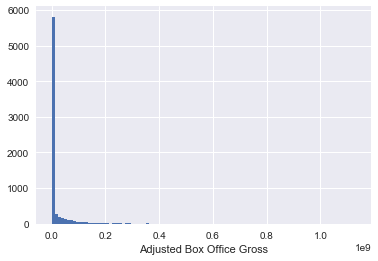

In [29]:
plt.hist(df['inflated_gross'], bins=100)
plt.xlabel('Adjusted Box Office Gross')

Even at 100 bins, the data is very heavily skewed in that small section of the data. Perhaps we have to do some feature engineering. We can look at return in terms of Box Office Gross, or as a percentage of its budget. Let's see how using a ratio between Box Office Gross and Budget performs.

(0.0, 600)

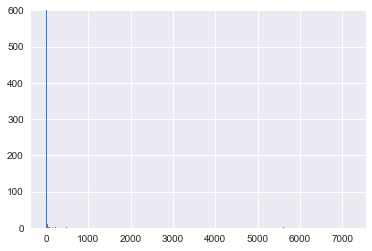

In [8]:
tmp_df = df[df['inflated_budget']>0]
pct_return = tmp_df['inflated_gross']/tmp_df['inflated_budget']
plt.hist(pct_return, bins = 500)
plt.ylim(ymin=0.0, ymax=600)

At first I thought there was an issue with code, but actually the issue became evident after increasing the granularity to an extreme level (bins = 500). There is a massive outlier at 7000. Next, there is a HUGE number of points with 0 as their ratio. This is the graph with only points greater than 0, limited x range, and even further increased granularity.

(0, 5)

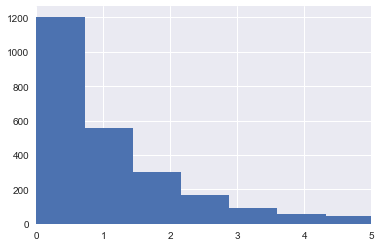

In [9]:
#pct_return.drop(pct_return[pct_return == max(pct_return)].index)
plt.hist(pct_return[pct_return>0], bins = 10000)
plt.xlim(xmin = 0, xmax = 5)

This histogram is clearly still in the same shape as the one for just adjusted box office gross. We'll try a log transformation to get around the skewedness.

Text(0.5,0,'log(pct_return), pct_return>0')

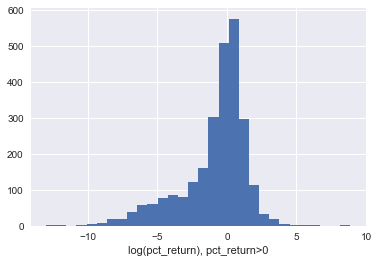

In [10]:
import math

plt.hist(pct_return[pct_return>0].apply(lambda x: math.log(x)), bins=30)
plt.xlabel('log(pct_return), pct_return>0')

Text(0.5,0,'log(pct_return+1)')

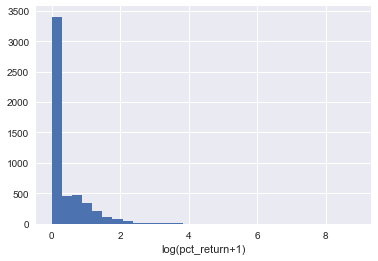

In [11]:
plt.hist((pct_return+1).apply(lambda x: math.log(x)), bins=30)
plt.xlabel('log(pct_return+1)')

Clearly adding 1 to all of the pct_return values is erroneous. This is because many of the values are between 0 and 1, indicating movies that lost money. If we add 1 to them, all of those values are suddenly shifted and they lose all meaning. Let's try replacing only the 0's with 1's.

Text(0.5,0,'log(pct_return), 0s mapped to 1')

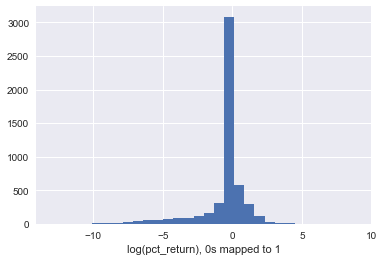

In [12]:
tmp_return = pct_return
tmp_return[pct_return==0] = tmp_return[pct_return==0]+1
plt.hist(tmp_return.apply(lambda x: math.log(x)), bins=30)
plt.xlabel('log(pct_return), 0s mapped to 1')

The histogram bears more useful information than the above one, however there is still an issue with the huge amount of 0s.

Text(0.5,0,'log(inflated_gross+1)')

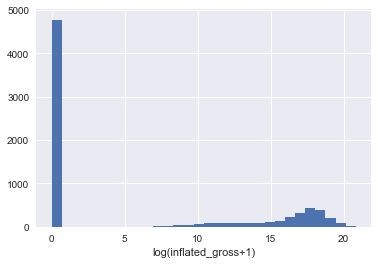

In [13]:
plt.hist((df['inflated_gross']+1).apply(lambda x: math.log(x)), bins=30)
plt.xlabel('log(inflated_gross+1)')

We've added 1 to each of the values because adding constants doesn't change variance, but allows us to avoid taking the log of 0. We have some separation between all of the points now, but there is still a huge pillar right around zero. This is expected because we had a lot of points at zero. It's unreasonable to believe that a movie grossed absolutely nothing at all. Let's look at this histogram with only values above 0.

Text(0.5,0,'log(inflated_gross), inflated_gross>0')

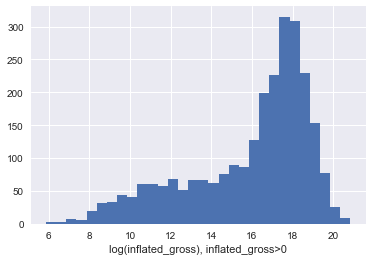

In [14]:
plt.hist(df['inflated_gross'][df['inflated_gross']>0].apply(lambda x: math.log(x)), bins=30)
plt.xlabel('log(inflated_gross), inflated_gross>0')

Based on these histograms, we'll most likely have to stick to **datapoints in which 'inflated_gross' and pct_return are greater than 0**, then apply **log transformations** to them.

### What factors determine the return of your movie?

In [15]:
df.corr()

,Unnamed: 0,imdbid,imdb_rating,imdb_votes,runtime,Budget,Box Office Gross,Fantasy,inflated_budget,inflated_gross,oscar,golden,bafta,primetime,win,nomination
Unnamed: 0,1.000000,0.055085,-0.014417,-0.218285,-0.074274,-0.005995,-0.242831,-0.064183,-0.005867,-0.209068,-0.094939,-0.050675,-0.004806,0.028015,-0.080305,-0.138672
imdbid,0.055085,1.000000,0.035656,-0.245009,-0.018568,0.012589,-0.207009,-0.067882,0.006656,-0.232548,-0.168511,-0.090493,-0.020349,0.022227,-0.105522,-0.124880
imdb_rating,-0.014417,0.035656,1.000000,0.232745,0.114993,0.020246,0.131912,-0.040448,0.020723,0.134421,0.235596,0.078162,0.065866,0.048520,0.257013,0.262551
imdb_votes,-0.218285,-0.245009,0.232745,1.000000,0.217046,0.032432,0.738670,0.114707,0.036353,0.708665,0.501053,0.116265,0.048051,-0.013591,0.514725,0.588345
runtime,-0.074274,-0.018568,0.114993,0.217046,1.000000,0.064337,0.166780,0.037941,0.066105,0.161880,0.186683,0.045953,0.019510,-0.003013,0.173257,0.203251
Budget,-0.005995,0.012589,0.020246,0.032432,0.064337,1.000000,0.039661,0.036420,0.999658,0.033977,0.010720,0.001623,-0.000257,-0.003022,0.029883,0.031582
Box Office Gross,-0.242831,-0.207009,0.131912,0.738670,0.166780,0.039661,1.000000,0.150524,0.043666,0.937230,0.398127,0.108492,0.045826,-0.014794,0.317783,0.403258
Fantasy,-0.064183,-0.067882,-0.040448,0.114707,0.037941,0.036420,0.150524,1.000000,0.037053,0.144304,0.060474,0.006168,-0.000715,-0.009606,0.020655,0.043834
inflated_budget,-0.005867,0.006656,0.020723,0.036353,0.066105,0.999658,0.043666,0.037053,1.000000,0.039650,0.015099,0.002925,-0.000112,-0.003183,0.030696,0.032526
inflated_gross,-0.209068,-0.232548,0.134421,0.708665,0.161880,0.033977,0.937230,0.144304,0.039650,1.000000,0.436202,0.101777,0.037282,-0.014311,0.304338,0.361692


In [16]:
zero_index = df[df['inflated_budget']==0].index
tmp_df = df.drop(zero_index)
tmp_df.corr()

,Unnamed: 0,imdbid,imdb_rating,imdb_votes,runtime,Budget,Box Office Gross,Fantasy,inflated_budget,inflated_gross,oscar,golden,bafta,primetime,win,nomination
Unnamed: 0,1.000000,-0.071191,-0.018152,-0.232923,-0.056851,0.001750,-0.268001,-0.080000,0.002404,-0.225486,-0.092204,-0.047377,0.004082,0.006909,-0.069090,-0.138823
imdbid,-0.071191,1.000000,0.039799,-0.212204,0.013980,0.039147,-0.168591,-0.061583,0.032489,-0.206423,-0.152365,-0.079060,-0.005772,0.012027,-0.066928,-0.072737
imdb_rating,-0.018152,0.039799,1.000000,0.276402,0.177206,0.020959,0.147342,-0.033200,0.021324,0.151065,0.276775,0.088155,0.075972,0.033604,0.289233,0.302924
imdb_votes,-0.232923,-0.212204,0.276402,1.000000,0.266539,0.023250,0.725980,0.113996,0.026752,0.695043,0.489419,0.101294,0.040138,-0.013306,0.508064,0.574982
runtime,-0.056851,0.013980,0.177206,0.266539,1.000000,0.079965,0.200772,0.040201,0.082049,0.194657,0.220057,0.049279,0.021532,-0.005858,0.206707,0.244398
Budget,0.001750,0.039147,0.020959,0.023250,0.079965,1.000000,0.031094,0.037238,0.999660,0.025544,0.004340,-0.001962,-0.002273,-0.002546,0.024651,0.024365
Box Office Gross,-0.268001,-0.168591,0.147342,0.725980,0.200772,0.031094,1.000000,0.155257,0.034699,0.934399,0.382588,0.094375,0.038339,-0.012846,0.302960,0.382526
Fantasy,-0.080000,-0.061583,-0.033200,0.113996,0.040201,0.037238,0.155257,1.000000,0.037788,0.148491,0.058528,0.001701,-0.003012,-0.007465,0.014033,0.035576
inflated_budget,0.002404,0.032489,0.021324,0.026752,0.082049,0.999660,0.034699,0.037788,1.000000,0.030865,0.008462,-0.000835,-0.002230,-0.002683,0.025175,0.024916
inflated_gross,-0.225486,-0.206423,0.151065,0.695043,0.194657,0.025544,0.934399,0.148491,0.030865,1.000000,0.422718,0.087880,0.029619,-0.012409,0.289422,0.339814


In [17]:
def corr_mat(corr):
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

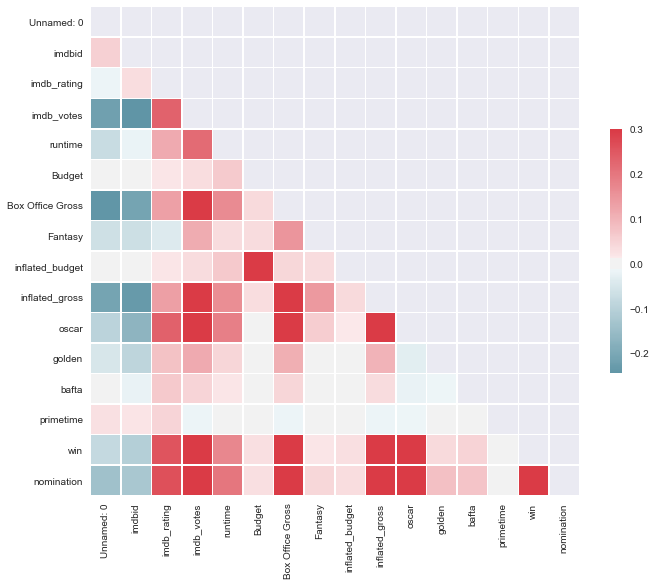

In [18]:
corr_mat(df.corr())

In [21]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

In [24]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

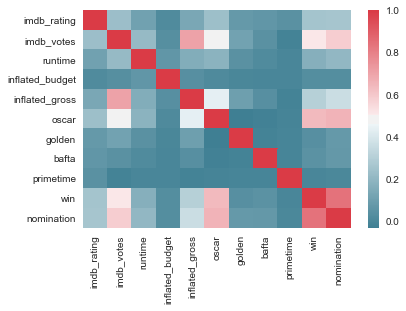

In [39]:
tmp_df = df.drop(['Unnamed: 0', 'imdbid','Budget','Box Office Gross'], axis = 1)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(tmp_df.corr(), cmap=cmap)